In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
np.array

<function numpy.core.multiarray.array>

In [4]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [20]:
%timeit sum(range(10_000_000))

152 ms ± 411 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit sum(list(range(10_000_000)))

363 ms ± 3.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
aa = np.arange(10_000_000)
%timeit np.sum(aa)

7.36 ms ± 73.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
%timeit np.sum(np.arange(10_000_000))

37.4 ms ± 400 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%%timeit
aa = np.arange(10_000_000)
np.sum(aa)

37.3 ms ± 421 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
bb = list(range(10_000_000))
%timeit np.sum(bb)

615 ms ± 37.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%load_ext line_profiler

In [45]:
import time
def slow_add(data):
    total = 0
    for el in data:
        
        total += el
    return total

slow_add([1, 2, 3, 4])    

10

In [46]:
%lprun -f slow_add slow_add([1, 2, 3, 4])

Timer unit: 1e-06 s

Total time: 5e-06 s
File: <ipython-input-45-3345e1409bbe>
Function: slow_add at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def slow_add(data):
     3         1          1.0      1.0     20.0      total = 0
     4         5          2.0      0.4     40.0      for el in data:
     5                                                   
     6         4          2.0      0.5     40.0          total += el
     7         1          0.0      0.0      0.0      return total

## Make Some Data to Fit

**Linear Model**

$$ y = mX + b $$
$$ y = m_1X_1 + m_2 X_2 $$
$$ y = m_1X_1 + m_2 1 $$
$$ y = m_1X_1 + m_2 $$
$$ y = mX $$

In [51]:
np.array([[1, 2, 3]]).T

array([[1],
       [2],
       [3]])

In [58]:
x = np.array([1, 2, 3])
x[:, None]

array([[1],
       [2],
       [3]])

In [56]:
x[None, :]

array([[1, 2, 3]])

In [60]:
np.matrix([1, 2, 3]).T

matrix([[1],
        [2],
        [3]])

## Generate Data

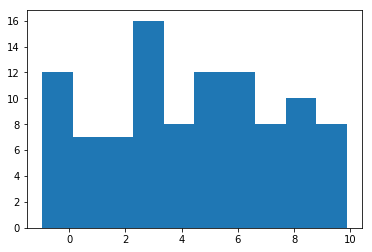

In [74]:
np.random.seed(10)
X = np.random.uniform(-1, 10, size=(100, 1))
plt.hist(X);


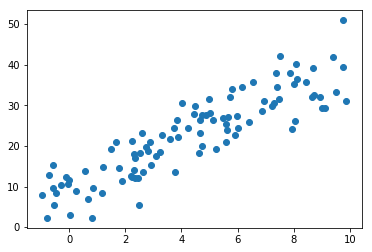

In [80]:
m = 3
b = 10
sigma = np.random.normal(0, 5, size=(100, 1))
y_obs = m * X + b + sigma

plt.scatter(X, y_obs);

## Fitting a Line with Numpy

In [101]:
x_plot = np.array([0, 10])
np_m = np.linalg.lstsq(X, y_obs, rcond=-1)[0]
np_m

array([[4.51192419]])

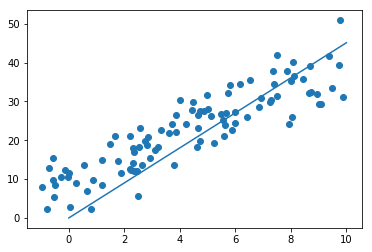

In [100]:
plt.scatter(X, y_obs);
plt.plot(x_plot, x_plot * np_m.flatten())

## Create a Column of 1s for X

In [108]:
np.ones_like(X);

In [110]:
X1 = np.hstack([X, np.ones_like(X)])
X1[:5]

array([[ 7.48452708,  1.        ],
       [-0.77172856,  1.        ],
       [ 5.97013058,  1.        ],
       [ 7.23684271,  1.        ],
       [ 4.48357714,  1.        ]])

In [147]:
(np_m2, np_b2), *_ = np.linalg.lstsq(X1, y_obs, rcond=-1)
np_m2, np_b2

(array([3.00484457]), array([9.71686859]))

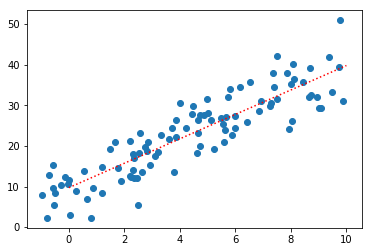

In [123]:
plt.scatter(X, y_obs);
plt.plot(x_plot, x_plot * np_m2.flatten() + np_b2, ':r');

## Regress a line with Scipy-Stats

In [148]:
from scipy import stats
result = stats.linregress(X.flatten(), y_obs.flatten())
result

LinregressResult(slope=3.0048445697693635, intercept=9.716868594006176, rvalue=0.8894115851586577, pvalue=4.3326207680696497e-35, stderr=0.15599989134993836)

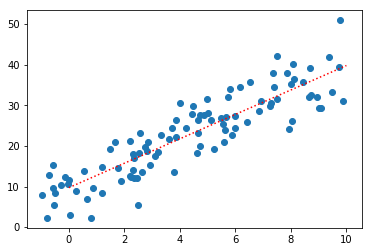

In [144]:
plt.scatter(X, y_obs);
plt.plot(x_plot, x_plot * result.slope + result.intercept, ':r');

## Regression with Scikit-Learn

In [156]:
from sklearn.linear_model import LinearRegression, ElasticNet

model = LinearRegression()
model.fit(X, y_obs)
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [159]:
model.coef_, model.intercept_

(array([[3.00484457]]), array([9.71686859]))

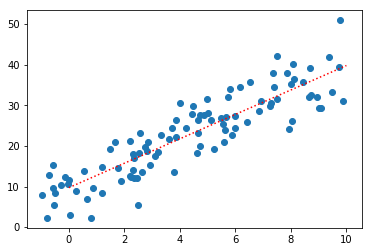

In [161]:
plt.scatter(X, y_obs);
plt.plot(x_plot, x_plot * model.coef_.flatten() + model.intercept_, ':r');

## Regression with PyMC3

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [noise]
>Metropolis: [b]
>Metropolis: [m]
Sampling 2 chains: 100%|██████████| 61000/61000 [00:19<00:00, 3208.18draws/s]
The number of effective samples is smaller than 10% for some parameters.


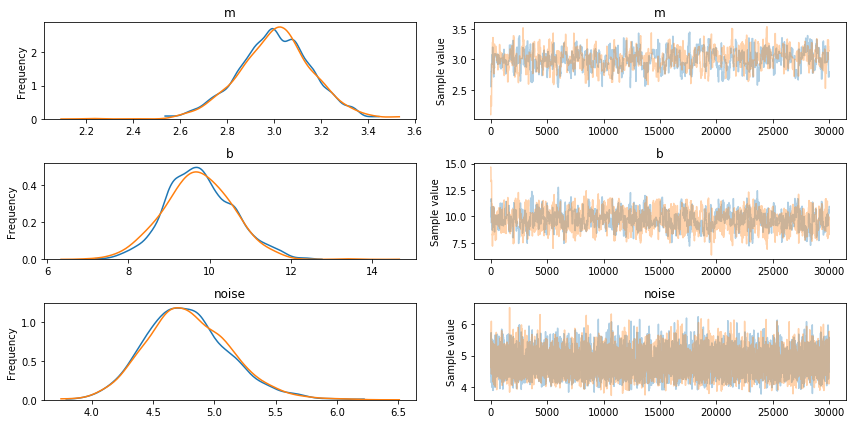

In [188]:
import pymc3 as pm

model = pm.Model()
with model:
    m = pm.Uniform('m', -1000, 1000)
    b = pm.Uniform('b', -100, 2000)
    noise = pm.HalfNormal('noise', 400)
    y = pm.Normal('y', mu = m * X + b, sd=noise, observed=y_obs)
    
    step = pm.Metropolis()
    trace = pm.sample(30000, step=step)

pm.traceplot(trace);